In [165]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import accuracy_score,precision_score,recall_score
import numpy as np

In [182]:
#Block One: First Filtering
#reading the CSV files, change them on your personal computer to wherever you saved them
rate = pd.read_csv(r'ml-latest-small/ratings.csv')
movies = pd.read_csv(r'ml-latest-small/movies.csv')
ratings = pd.read_csv(r'ml-latest-small/ratings.csv')
tags = pd.read_csv(r'ml-latest-small/tags.csv')

#dropping timestamp as it's unnecessary
tags = tags.drop(columns='timestamp')
ratings = ratings.drop(columns='timestamp') 

#Groups on userId and movieId and groups tags into a list
tags = tags.groupby(['movieId']).agg({'tag':set}).reset_index()

#Refining ratings to just be movieId and the average rating to only 1 decimal point
ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
ratings = ratings.rename(columns={'rating':'average_rating'})
ratings['average_rating'] = ratings['average_rating'].round(1)
filtered_data = pd.merge(movies,ratings, on='movieId')
filtered_data = pd.merge(filtered_data, tags, on='movieId')

#Block Two: Unique Genres and Second Filtering
# Split genres by '|' and get all unique genres
unique_genres = set()
for genres in movies['genres']:
    unique_genres.update(genres.split('|'))
unique_genres = sorted(unique_genres)  # Sort in alphabetic order
for genre in unique_genres:
    filtered_data[genre] = filtered_data['genres'].apply(lambda x: 1 if genre in x.split('|') else 0)
#filter out In Netflix Queue
filtered_data['tag'] = filtered_data['tag'].apply(lambda tag_set: {tag for tag in tag_set if tag != "In Netflix queue"})

# Drop the original 'genres' column (I think it's a good idea, no need to clutter the data yk?)
filtered_data= filtered_data.drop(columns=['genres'])


#Block Three: Vectorization
#I changed the vector size to 10 just cause it's smaller but if you wanna increase it by all means go for it
wordVector = Word2Vec(filtered_data['tag'].tolist(),vector_size=10, window=5, min_count=1, workers=4)

vector_size = 10  # Same size as Word2Vec vectors
padding_vector = np.zeros(vector_size)
# Function to generate a vector for up to 3 tags
def create_feature_vector(row):
    # Get word vectors for the tags, up to 3 tags, and pad if fewer
    tag_vectors = [
        wordVector.wv[tag] if tag in wordVector.wv else padding_vector
        for tag in list(row['tag'])[:3]
    ]
    while len(tag_vectors) < 3:  # Pad with zero vectors if fewer than 3 tags
        tag_vectors.append(padding_vector)
    
    # Flatten the tag vectors (3 vectors of size 10 each -> 30 elements)
    tag_vector = np.concatenate(tag_vectors)
    
    # Add genre one-hot encoding
    genre_vector = row[unique_genres].values  # One-hot encoded genres
    
    # Combine tag vector and genre vector
    feature_vector = np.concatenate([tag_vector, genre_vector])
    return feature_vector
filtered_data['feature_vector'] = filtered_data.apply(create_feature_vector, axis=1)

#Okay so I mixed the tag vector and the genre vectors into one feature vector
#I am going to drop the original tag vector and the genres
filtered_data = filtered_data.drop(columns=list(unique_genres))
filtered_data = filtered_data.drop(columns='tag')

#wrote to file to see feature data
# filtered_data.to_csv('filtered_movies.csv',index=False)

#Block 4: The actual recommendation

#TODO: implement the test and training sets split

#Query is the movie we want to isolate
#Cosine Similarities
def knn_recommendation_cos(query,train_data,k=5):
    #Extract ratings and feature vectors from training set
    #Ratings are optional if you don't want them, I have them here to use as bias
    train_features = np.array(train_data['feature_vector'].tolist())
    train_ratings = train_data['average_rating'].values#Optional

    #kNN using cosine_similarity
    similarities = cosine_similarity([query],train_features).flatten()

    #Optional Bias
    weighted_similarities = similarities * train_ratings

    #get the indicies of nearest movies (5)
    kNN_indices = np.argsort(weighted_similarities)[-k:][::-1] #Sorted by weighted similariy in descending order

    #Get the movies from the index
    kNN_movies = train_data.iloc[kNN_indices]
    return kNN_movies

#if you want to compare cosine to euclidean distance
def knn_recommendation_eucl(query,train_data,k=5):
    #Extract ratings and feature vectors from training set
    #Ratings are optional if you don't want them, I have them here to use as bias
    train_features = np.array(train_data['feature_vector'].tolist())
    train_ratings = train_data['average_rating'].values#Optional

    #kNN using euclidean distances
    distances = euclidean_distances([query],train_features).flatten()

    #Optional Bias
    weighted_distances= distances / train_ratings

    #get the indicies of nearest movies (5)
    kNN_indices = np.argsort(weighted_distances)[:k] #Sorted by weighted distances ascending order

    #Get the movies from the index
    kNN_movies = train_data.iloc[kNN_indices]
    return kNN_movies


def test_knn(test_data,train_data,k=5):
    for _,row in test_data.iterrows():
        query = np.array(row['feature_vector'])
        knn_movies = knn_recommendation_cos(query,train_data,k)
        print(f"Current Movie searched: {row['title']}")
        print("Recommended Movies: ")
        print(knn_movies[['title','average_rating']])
        print()

In [183]:
# Create a dataframe with the combination of filter_data and rating
# The dataframe will have the users grouped with the movies feature_vector
def my_train(df, filt_data):
    # Create empty lists to store train and test data
    train_list = []

    merged_df = pd.merge(df, filt_data, on='movieId')
    grouped = merged_df.groupby('userId')

    for user, group in grouped:
        # Sort movies by rating in descending order
        sorted_group = group.sort_values(by='movieId', ascending=True)
        
        # Use the rest for training
        train = sorted_group.iloc[:]
        
        # Append to respective lists
        train_list.append(train)

    train_data = pd.concat(train_list).reset_index(drop=True)

    return train_data

In [184]:
train_data = my_train(rate, filtered_data)
# specific user and movie
user_id = 1
user = train_data[train_data['userId'] == user_id]
movie = user[user['movieId'] == 1] # movie has to be valid movie of user

# print(movie['feature_vector'])
test_knn(movie, filtered_data, 6)

# This will print recommendations for all user's movies
# test_knn(user, filtered_data, 6)

Current Movie searched: Toy Story (1995)
Recommended Movies: 
                                           title  average_rating
0                               Toy Story (1995)             3.9
664                           Toy Story 2 (1999)             3.9
1010                         Finding Nemo (2003)             4.0
807                                 Shrek (2001)             3.9
1479                       The Lego Movie (2014)             3.9
1268  Cat Returns, The (Neko no ongaeshi) (2002)             3.8



In [185]:
# test specifict movie (*some movies ids do not exit, Reason: not enough data)
movie_id = 2
movie_by_id = filtered_data[filtered_data['movieId'] == movie_id]
movie_querry = np.array(movie_by_id['feature_vector'].iloc[0])

# test specifict movie
knn_movies = knn_recommendation_cos(movie_querry, filtered_data, 6)
print(f"Recommended movies for {movie_by_id['title'].values[0]}:\n{knn_movies['title']}")

Recommended movies for Jumanji (1995):
861     Harry Potter and the Sorcerer's Stone (a.k.a. ...
1385     Chronicles of Narnia: Prince Caspian, The (2008)
1                                          Jumanji (1995)
1335    Chronicles of Narnia: The Lion, the Witch and ...
201                              Wizard of Oz, The (1939)
1268           Cat Returns, The (Neko no ongaeshi) (2002)
Name: title, dtype: object


## User base knn_evaluation

The way the funciton works is similar to how knn works with classifing data like apple and oranges. The idea is that movies that the user rated as good will share similar traits to movies that the user has already liked or would like. Same thing with bad movies.

To validate this idea we only use the movies that the user has seen and rated. We classify the movies as Good if they are rated above 3, and Bad for everything else. Now we can use it as a regular knn. 

We split our user movies as training and testing data and let the model classify the movies as bad or good according to the majority vote of movies it find itself similar too. From there we can get our models accuracy, precision, and recall.

In [186]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

def user_based_knn_evaluation(user_id, ratings, filtered_data, k=5):
    # Extract Data for the User
    user_ratings = ratings[ratings['userId'] == user_id]
    user_data = pd.merge(user_ratings, filtered_data, on='movieId')
    user_data['target'] = (user_data['rating'] >= 3).astype(int)  # Good = 1, Bad = 0
    
    # Split Data into Training and Testing
    train_data, test_data = train_test_split(user_data, test_size=0.2, random_state=42)
    
    # Train and Test the kNN Model
    y_true = []
    y_pred = []
    
    for _, row in test_data.iterrows():
        query_vector = np.array(row['feature_vector'])
        k_nearest_movies = knn_recommendation_cos(query_vector, train_data, k=k)
        
        # Majority vote for the target (Good/Bad) among k neighbors
        majority_vote = k_nearest_movies['target'].mode()[0]
        y_true.append(row['target'])
        y_pred.append(majority_vote)
    
    # Compute Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Confusion Matrix": conf_matrix,
    }

# Example Usage
user_id = 15  # Specify the user ID
metrics = user_based_knn_evaluation(user_id, rate, filtered_data, k=5)
print("Metrics for User", user_id, ":", metrics)

Metrics for User 15 : {'Accuracy': 0.75, 'Precision': 0.75, 'Recall': 1.0, 'Confusion Matrix': array([[ 0,  4],
       [ 0, 12]])}


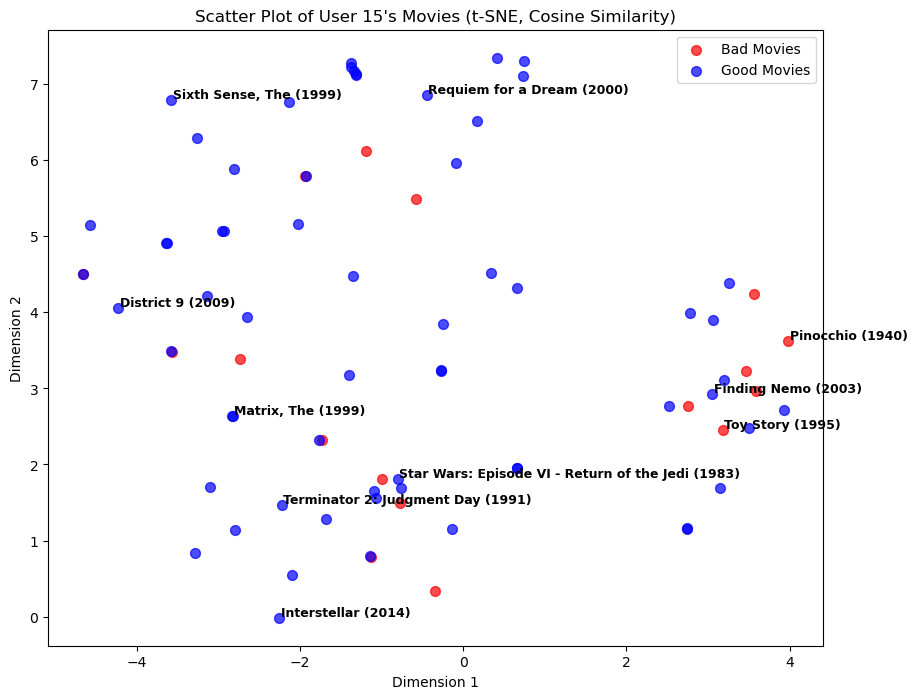

In [181]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

def user_scatter_plot(user_id, ratings, filtered_data, k=5):
    # Step 1: Extract Data for the User
    user_ratings = ratings[ratings['userId'] == user_id]
    user_data = pd.merge(user_ratings, filtered_data, on='movieId')
    user_data['target'] = (user_data['rating'] >= 3).astype(int)  # Good = 1, Bad = 0

    # Feature vectors and titles
    feature_vectors = np.array(user_data['feature_vector'].tolist())
    movie_titles = user_data['title']
    targets = user_data['target']  # 1 for good, 0 for bad

    # Reduce feature vectors to 2D using t-SNE
    tsne = TSNE(n_components=2, metric='cosine', random_state=42)
    reduced_features = tsne.fit_transform(feature_vectors)

    # Scatter Plot
    plt.figure(figsize=(10, 8))
    for label, color in zip([0, 1], ['red', 'blue']):
        mask = targets == label
        plt.scatter(
            reduced_features[mask, 0],
            reduced_features[mask, 1],
            label=f'{"Good" if label == 1 else "Bad"} Movies',
            alpha=0.7,
            s=50,
            c=color,
        )
    
    # Annotate random movies
    random_indices = random.sample(range(len(movie_titles)), 10)
    for i in random_indices:
        plt.text(
            reduced_features[i, 0] + 0.02,
            reduced_features[i, 1] + 0.02,
            movie_titles.iloc[i],
            fontsize=9,
            fontweight='bold',
            color='black',
        )

    plt.title(f"Scatter Plot of User {user_id}'s Movies (t-SNE, Cosine Similarity)")
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

user_id = 15  # Replace with the desired user ID
user_scatter_plot(user_id, rate, filtered_data)